In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
!pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.15.0-py3-none-any.whl size=5224 sha256=92975c8a44ef1c371422e25f8d435951f7b780bc9908d66e867b261a702723cb
  Stored in directory: /root/.cache/pip/wheels/4d/be/fe/55422f77ac11fe6ddcb471198038de8a26b5a4dd1557883c1e
Successfully built keras-layer-normalization


In [ ]:
class Config:
  DATASET_PATH ="/content/drive/My Drive/datasets/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/"
  DATASET_PATH1="/content/drive/My Drive/datasets/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/Train002/"
  SINGLE_TEST_PATH = "/content/drive/My Drive/datasets/UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test001"
  BATCH_SIZE = 4
  EPOCHS = 5
  MODEL_PATH = "/content/drive/My Drive/datasets/notebooks/lstmautoencoder/model_2.hdf5"

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips



    

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LayerNormalization
from keras.layers import Input, Dense

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6), metrics=["accuracy"])
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [ ]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


In [ ]:
def get_normal_vid(path):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(path)):
        if str(join(path, f))[-3:] == "tif":
            img = Image.open(join(path, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test
    

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.callbacks import History 
history = History()

def evaluate():
    model = get_model(False)
    print(model.summary())
    print("got model")
    # Plot of the model training loss
    print(model.history.history.keys())
    
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    mse2=np.mean([np.power(np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])),2)for i in range(0,sz)])
    mse = np.array([np.power(np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])),2)for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    mean_error=mse2
    threshold=165
    ylabel=[]
    for i in range(len(mse)):
      if i<146:
        ylabel.append(0)
      #elif i>=8 and i<threshold:			
        #ylabel.append(1)
      #elif i>=threshold and i<113:
        #ylabel.append(1)
      else:
        ylabel.append(1)

    auc_score = roc_auc_score(y_true=ylabel, y_score=mse)
    fpr = dict()
    tpr = dict()
    print(len(ylabel))
    print(len(mse))
    fpr, tpr,thresholds = roc_curve(ylabel, mse)
    roc_auc=auc(fpr,tpr)
    # calculating the mean squared error reconstruction loss per row in the numpy array
    #fpr, tpr, thresholds = metrics.roc_curve(sr, mse)
    #plt.plot(mse)
    #plt.ylabel('MSE Loss')
    #plt.xlabel('frame t')
    #plt.show()
    plt.plot(model.history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


    print(mse.shape)
    #mse=mse.flatten()
    print(mse.shape)
    plt.plot(mse)
    plt.title('Plot of Frames Reconstruction Error')
    plt.ylabel('Reconstruction Error - MSE')
    plt.xlabel('frame t')
    plt.show()

    #plot ground truth
    plt.plot(ylabel)
    plt.title('Plot of Video Frames Ground Truth')
    plt.ylabel('Anomaly Presence')
    plt.xlabel('frame t')
    plt.show()
    

    # plot the regularity scores
    plt.plot(sr)
    plt.title('Plot of Regularity Score per Frame')
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    #plotting the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic For CONVLSTM Model')
    plt.legend(loc="lower right")
    plt.show() 
    

In [ ]:
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_7 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_8 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

KeyError: ignored

In [ ]:
#ped2 001
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_7 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_8 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

In [ ]:
#training ped2
evaluate()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization (LayerNo (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 32)    1

AttributeError: ignored

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

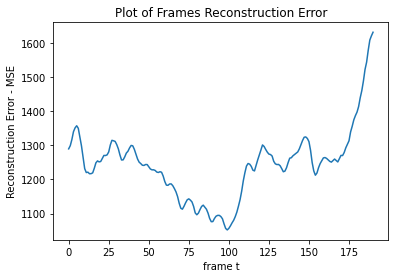

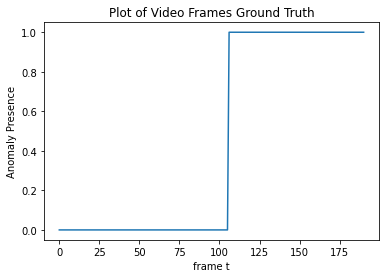

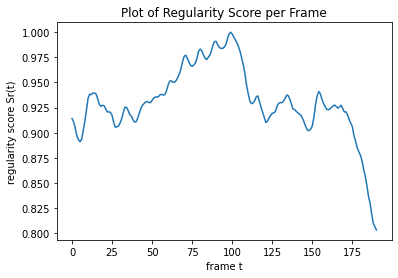

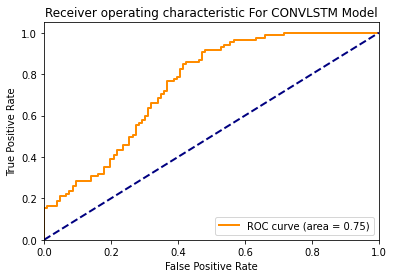

In [ ]:
#028
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

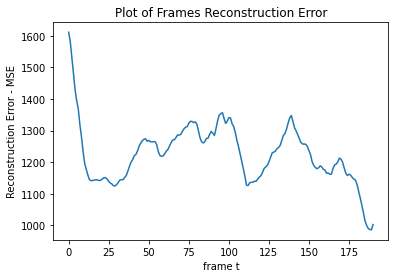

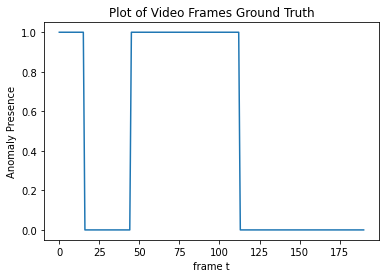

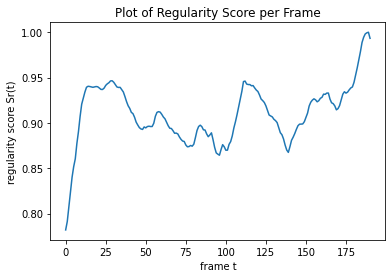

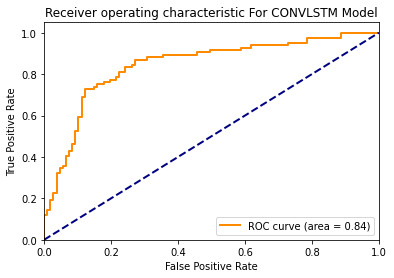

In [ ]:
#029
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

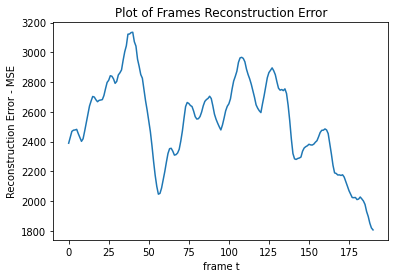

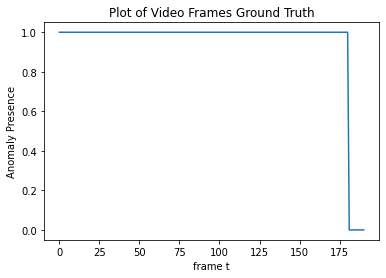

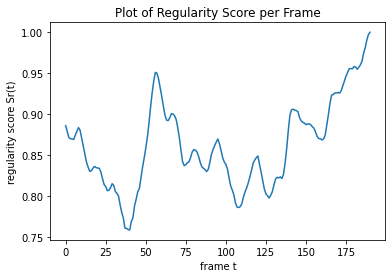

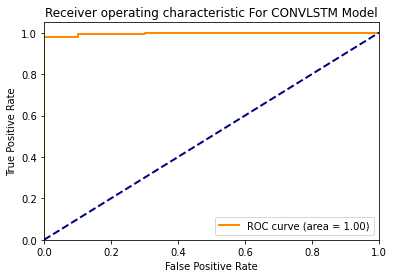

In [ ]:
#031
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

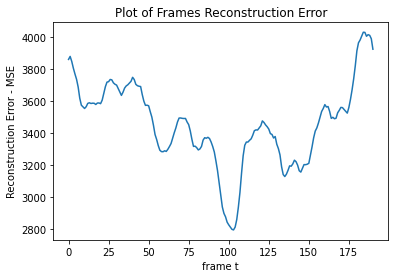

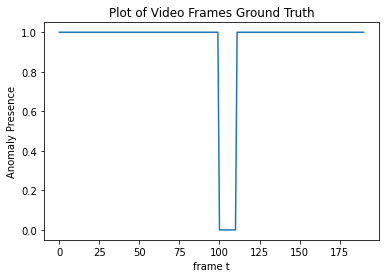

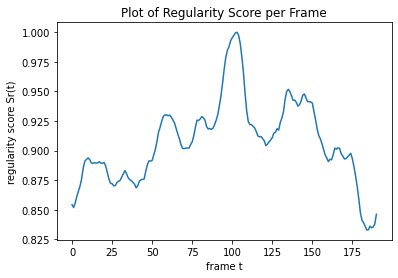

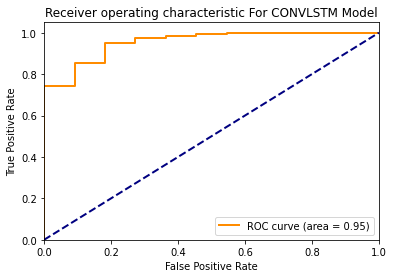

In [ ]:
#006
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

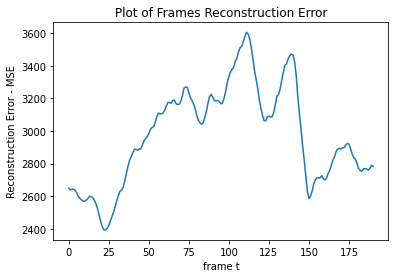

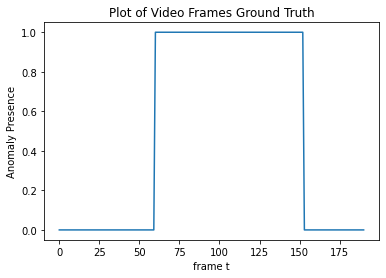

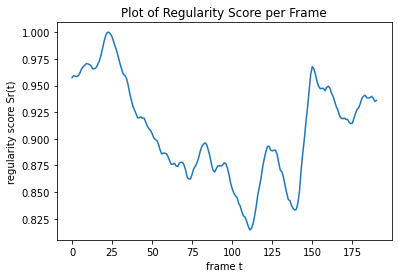

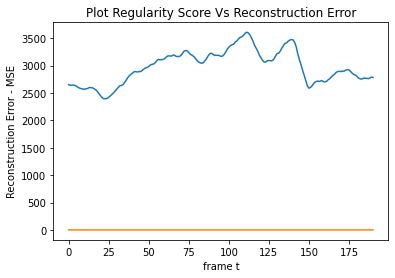

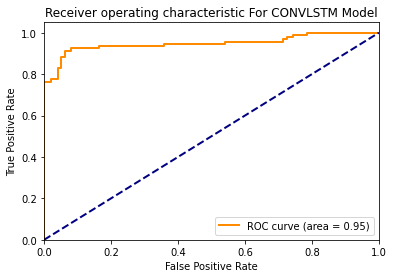

In [ ]:
evaluate()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

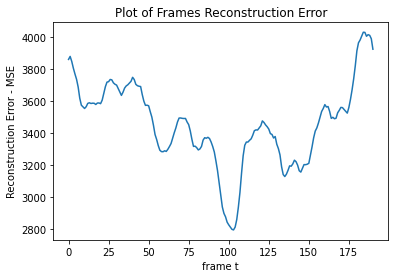

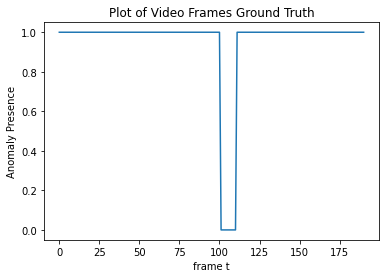

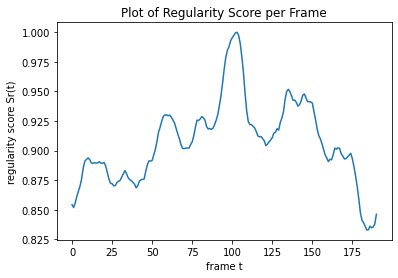

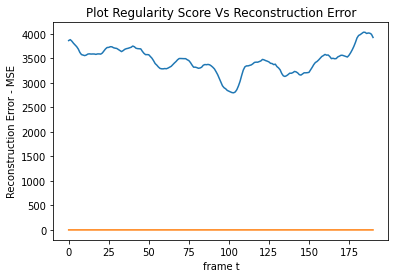

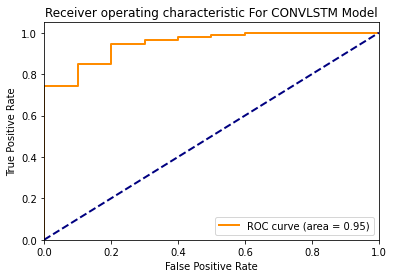

In [ ]:
evaluate()

got model
(200, 256, 256, 1)
got data
191
191
(191,)
(191,)


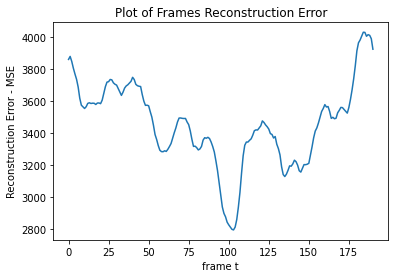

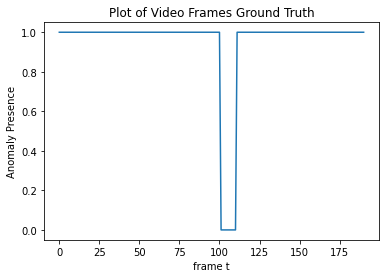

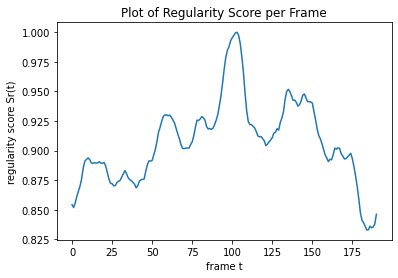

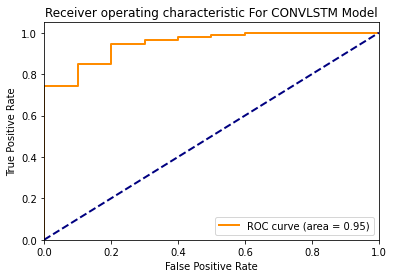

In [ ]:
evaluate()

Introduction of One Class SVM to detect anomalies.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from numpy import quantile, where, random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def svm_training_features():
    # loop over the training folders (Train000,Train001,..)
    model = get_model(False)
    print("got model")
    print(model.summary())
    all_recon_cost=[]
    #for f in sorted(listdir(Config.DATASET_PATH)):
        #if isdir(join(Config.DATASET_PATH, f)):
            #all_frames = []
    test= get_normal_vid(Config.DATASET_PATH1)
    #test=get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    mse = np.array([np.power(np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])),2)for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.title('Plot of Regularity Score per Frame')
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()
    #All regularity scores of normal videos
    #print(all_recon_cost.shape())
    #One Class SVM
    train_feature=pd.DataFrame(mse)
    print('Oneclass SVM training')
    oneclass=svm.OneClassSVM(kernel='linear', gamma=0.0001, nu=0.99)
    oneclass.fit(train_feature)
    y_pred=oneclass.predict(train_feature)
    regscore=pd.DataFrame(sr)
    print(regscore.head())
    print('reached here')
    print(y_pred)
    y_pred = pd.DataFrame(y_pred)
    print(y_pred.head())
    
    #Marking Anomalies in the Regularity score
    anomaly_index=[]
    normal_index=[]
    for j in range(len(y_pred)):
        if y_pred[0][j] == 1:
            normal_index.append(j)
        else:
            anomaly_index.append(j)
        
    print(anomaly_index)
    print(normal_index)


    anomaly_values = regscore[anomaly_index]
    normal_values =  regscore[normal_index]

    #print (agg_sr.head())
    plt.plot(sr)
    plt.scatter(anomaly_values[:,0], color='r')
    plt.scatter(nomal_values[:,0], color='b')
    plt.title('Plot of Anomaly Score per Frame')
    plt.ylabel('Anomaly/Reg Score Sr(t)')
    plt.xlabel('frame t')
    
    plt.show()


    return y_pred  
    

In [ ]:
def svm_detector_training():
    from sklearn import svm
    import pandas as pd
    import numpy as np
    train_feature=svm_training_features()
    train_feature=pd.DataFrame(train_feature)
    print('Oneclass SVM training')
    oneclass=svm.OneClassSVM(kernel='linear', gamma=0.001, nu=0.95)
    oneclass.fit(train_feature)
    feature_pred=oneclass.predict(train_feature)
    return feature_pred

In [ ]:
def svm_testing():
    
    model = get_model(False)
    print("Got Model")
    #test shape
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    test_feature=sequences_reconstruction_cost
    print ('Got Testing set')
    X_test=pd.DataFrame(test_feature)
    oneclass=svm_detector_training()
    #check outliers predicted on single test case
    fraud_pred = oneclass.predict(X_test)
    return fraud_pred



In [ ]:
def svm_evaluation():
    y_pred= svm_training_features()
    y_pred = pd.DataFrame(y_pred)
    y_pred= y_pred.rename(columns={0: 'prediction'})
    #compare prediction with ground truth
    #Populating Ground truth
    threshold=100
    ylabel=[]
    for i in range(len(y_pred)):
      if i<threshold:
        ylabel.append(1)
      elif i>threshold and i<=110:			
        ylabel.append(0)
      else:
        ylabel.append(1)
    Y_test=pd.DataFrame(ylabel)
    Y_tes= Y_test.rename(columns={0:'Category'})

    #Calculation of TP
    TP = FN = FP = TN = 0
    for j in range(len(Y_test)):
        if Y_test[0][j]== 0 and y_pred[0][j] == 1:
            TP = TP+1
        elif Y_test[0][j]== 0 and y_pred[0][j] == -1:
            FN = FN+1
        elif Y_test[0][j]== 1 and y_pred[0][j] == 1:
            FP = FP+1
        else:
            TN = TN +1
    print (TP,  FN,  FP,  TN)

    # Performance Matrix

    accuracy = (TP+TN)/(TP+FN+FP+TN)
    print (accuracy)
    sensitivity = TP/(TP+FN)
    print (sensitivity)
    specificity = TN/(TN+FP)
    print (specificity)

got model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 32, 

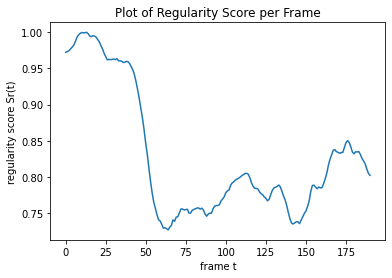

Oneclass SVM training
          0
0  0.972276
1  0.973284
2  0.974305
3  0.976701
4  0.979253
reached here
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
   0
0 -1
1 -1
2 -1
3 -1
4 -1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74

KeyError: ignored

In [ ]:
svm_evaluation()